# Flight Delay Analysis - Feature Engineering

## Phase 3: Creating Features for Model Training

In [1]:
import sys
sys.path.append('..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.model_selection import train_test_split

# Import feature engineering functions
from src.data.feature_engineering import (
    create_basic_features,
    encode_categorical_features,
    select_features_for_modeling,
    feature_engineering_pipeline
)

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print("✓ Imports complete")

✓ Imports complete


In [2]:
# Reload external files
%load_ext autoreload
%autoreload 2

---
## Part 1: Load Cleaned Data
---

In [3]:
# Load the cleaned dataset from preprocessing
input_path = '../data/processed/flight_delays_cleaned.csv'
df_clean = pd.read_csv(input_path)

print(f"Cleaned data shape: {df_clean.shape}")
print(f"Memory usage: {df_clean.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

print("CLEANED DATA OVERVIEW")
print(f"\nColumns ({len(df_clean.columns)}):")
for i, col in enumerate(df_clean.columns, 1):
    print(f"  {i:2}. {col}")

print(f"\nSample data:")
df_clean.head()

Cleaned data shape: (1527160, 17)
Memory usage: 750.04 MB
CLEANED DATA OVERVIEW

Columns (17):
   1. Carrier Code
   2. Date (YYYY-MM-DD)
   3. Flight Number
   4. Tail Number
   5. Origin Airport
   6. Scheduled Arrival Time
   7. Actual Arrival Time
   8. Scheduled Elapsed Time (Minutes)
   9. Actual Elapsed Time (Minutes)
  10. Arrival Delay (Minutes)
  11. Wheels-on Time
  12. Taxi-In time (Minutes)
  13. Delay Carrier (Minutes)
  14. Delay Weather (Minutes)
  15. Delay National Aviation System (Minutes)
  16. Delay Security (Minutes)
  17. Delay Late Aircraft Arrival (Minutes)

Sample data:


,Carrier Code,Date (YYYY-MM-DD),Flight Number,Tail Number,Origin Airport,Scheduled Arrival Time,Actual Arrival Time,Scheduled Elapsed Time (Minutes),Actual Elapsed Time (Minutes),Arrival Delay (Minutes),Wheels-on Time,Taxi-In time (Minutes),Delay Carrier (Minutes),Delay Weather (Minutes),Delay National Aviation System (Minutes),Delay Security (Minutes),Delay Late Aircraft Arrival (Minutes)
0,9E,2019-01-01,3280,N8688C,GNV,07:23,07:22,83,81,-1,07:14,8,0,0,0,0,0
1,9E,2019-01-01,3283,N8886A,TLH,16:39,16:25,72,64,-14,16:18,7,0,0,0,0,0
2,9E,2019-01-01,3286,N915XJ,JAN,18:23,18:32,85,99,9,18:18,14,0,0,0,0,0
3,9E,2019-01-01,3289,N311PQ,BMI,17:07,17:00,112,110,-7,16:55,5,0,0,0,0,0
4,9E,2019-01-01,3290,N931XJ,CAK,08:09,07:37,129,100,-32,07:31,6,0,0,0,0,0


In [4]:
# Check data quality
print("DATA QUALITY CHECK")

print(f"\nTotal rows: {len(df_clean):,}")
print(f"Missing values: {df_clean.isna().sum().sum()}")
print(f"Duplicate rows: {df_clean.duplicated().sum()}")

print(f"\nTarget variable (Arrival Delay) statistics:")
print(df_clean['Arrival Delay (Minutes)'].describe())

DATA QUALITY CHECK

Total rows: 1,527,160
Missing values: 0
Duplicate rows: 0

Target variable (Arrival Delay) statistics:
count    1.527160e+06
mean     3.105137e+00
std      5.249457e+01
min     -8.600000e+01
25%     -1.600000e+01
50%     -8.000000e+00
75%      3.000000e+00
max      1.694000e+03
Name: Arrival Delay (Minutes), dtype: float64


In [5]:
# Detect newest date available in df_clean
import pandas as pd

# Candidate date columns (ordered by preference)
candidate_cols = ['Date (YYYY-MM-DD)', 'Date', 'FL_DATE', 'Flight Date']
found_col = None
for col in candidate_cols:
    if col in df_clean.columns:
        found_col = col
        break

if found_col is None:
    print("No known date column found. Checked:", candidate_cols)
else:
    print(f"Using date column: {found_col}")
    dates = pd.to_datetime(df_clean[found_col], errors='coerce')
    n_na = dates.isna().sum()
    if n_na > 0:
        print(f"Note: {n_na:,} rows had non-parsable dates and were ignored in this check.")

    if dates.notna().any():
        min_date = dates.min()
        max_date = dates.max()
        print("\nData recency:")
        print(f"  Earliest date: {min_date.date() if pd.notna(min_date) else 'N/A'}")
        print(f"  Latest date:   {max_date.date() if pd.notna(max_date) else 'N/A'}")

        # Coverage in the last 30 days relative to the latest date
        anchor = pd.Timestamp(max_date.date())
        recent_mask = dates >= (anchor - pd.Timedelta(days=30))
        recent_count = recent_mask.sum()
        print(f"\nRows in last 30 days from latest date: {recent_count:,} ({recent_count/len(df_clean)*100:.2f}%)")

        # Show top 10 most recent dates with counts
        by_day = dates.dt.date.value_counts().sort_index()
        tail = by_day.tail(10)
        print("\nMost recent dates (last 10) with row counts:")
        for d, c in tail.items():
            print(f"  {d}: {c:,}")

        # Monthly coverage (last 6 months)
        by_month = dates.dt.to_period('M').value_counts().sort_index()
        tail_m = by_month.tail(6)
        print("\nMonthly coverage (last 6 months):")
        for m, c in tail_m.items():
            print(f"  {m}: {c:,}")

        # Optional: per-carrier latest date if carrier column exists
        if 'Carrier Code' in df_clean.columns:
            latest_by_carrier = df_clean.assign(_date=dates).groupby('Carrier Code')['_date'].max().sort_values()
            print("\nLatest date by carrier (sample):")
            print(latest_by_carrier.tail(10))
    else:
        print("All dates are NaT after parsing; please verify the date format.")

Using date column: Date (YYYY-MM-DD)

Data recency:
  Earliest date: 2019-01-01
  Latest date:   2025-07-31

Rows in last 30 days from latest date: 29,218 (1.91%)

Most recent dates (last 10) with row counts:
  2025-07-22: 941
  2025-07-23: 938
  2025-07-24: 1,006
  2025-07-25: 1,007
  2025-07-26: 835
  2025-07-27: 1,003
  2025-07-28: 1,007
  2025-07-29: 941
  2025-07-30: 938
  2025-07-31: 1,005

Monthly coverage (last 6 months):
  2025-02: 23,997
  2025-03: 28,383
  2025-04: 27,189
  2025-05: 28,625
  2025-06: 28,594
  2025-07: 29,218

Latest date by carrier (sample):
Carrier Code
9E   2025-07-31
AA   2025-07-31
AS   2025-07-31
DL   2025-07-31
MQ   2025-07-31
NK   2025-07-31
OO   2025-07-31
UA   2025-07-31
WN   2025-07-31
YX   2025-07-31
Name: _date, dtype: datetime64[ns]


### Quick check: What is the newest date in the dataset?
This cell detects a date column (prefers `Date (YYYY-MM-DD)` if present), parses it safely, and reports min/max dates and recent coverage.

---
## Part 2: Feature Engineering Pipeline
---

### 2.1 Run Feature Engineering Pipeline

In [6]:
# Run the complete feature engineering pipeline
output_path = '../data/processed/flight_delays_engineered.csv'

df_engineered, feature_cols, label_encoders = feature_engineering_pipeline(
    input_path=input_path,
    output_path=output_path
)

print("\nFeature engineering pipeline complete!")

FEATURE ENGINEERING PIPELINE (SIMPLIFIED)

Loading data from: ../data/processed/flight_delays_cleaned.csv
Loaded 1,527,160 rows, 17 columns
CREATING BASIC FEATURES
✓ Created IsWeekend
✓ Created Is_Holiday_Period
Created Season
Created Is_Delayed

Feature summary:
  - IsWeekend: 409,624 (26.82%)
  - Is_Holiday_Period: 172,663 (11.31%)
  - Season: {'Spring': 424732, 'Summer': 407486, 'Winter': 362732, 'Fall': 332210}
  - Is_Delayed: 232,861 (15.25%)

ENCODING CATEGORICAL FEATURES

One-hot encoding Carrier Code...
Created 11 carrier dummy variables

Label encoding Origin Airport...
Encoded 173 unique airports

Label encoding Season...
Encoded Season: {'Fall': np.int64(0), 'Spring': np.int64(1), 'Summer': np.int64(2), 'Winter': np.int64(3)}

 Encoding complete. Total columns: 36
SELECTING FEATURES FOR MODELING

Total features: 16

Features for modeling:
   1. Scheduled Elapsed Time (Minutes)
   2. IsWeekend
   3. Is_Holiday_Period
   4. Carrier_9E
   5. Carrier_AA
   6. Carrier_AS
   7. Ca

### 2.2 Inspect Engineered Features

In [7]:
# Inspect new features
print("NEW FEATURES CREATED")

# Show new feature columns
new_features = [col for col in df_engineered.columns if col not in df_clean.columns]
print(f"\nNew features ({len(new_features)}):")
for i, col in enumerate(new_features, 1):
    print(f"  {i:2}. {col}")

print(f"\nSample of engineered data:")
# Only display columns that exist in df_engineered
display(df_engineered[['Date (YYYY-MM-DD)', 'IsWeekend', 'Is_Holiday_Period', 
                        'Season_Encoded', 'Is_Delayed']].sample(10))

NEW FEATURES CREATED

New features (16):
   1. IsWeekend
   2. Is_Holiday_Period
   3. Carrier_9E
   4. Carrier_AA
   5. Carrier_AS
   6. Carrier_DL
   7. Carrier_EV
   8. Carrier_MQ
   9. Carrier_NK
  10. Carrier_OO
  11. Carrier_UA
  12. Carrier_WN
  13. Carrier_YX
  14. Origin_Airport_Encoded
  15. Season_Encoded
  16. Is_Delayed

Sample of engineered data:


,Date (YYYY-MM-DD),IsWeekend,Is_Holiday_Period,Season_Encoded,Is_Delayed
318769,2024-02-19,0,0,3,0
1479972,2019-10-11,0,0,0,0
434511,2023-03-29,0,0,1,1
1216172,2024-12-30,0,1,3,0
593100,2024-05-18,1,0,1,0
88682,2019-07-31,0,0,2,0
1310482,2024-08-27,0,0,2,1
447897,2024-04-02,0,0,1,0
1309689,2019-08-22,0,0,2,0
125133,2024-12-03,0,0,3,0


In [8]:
# Feature statistics
print("FEATURE STATISTICS")

# IsWeekend
weekend_count = df_engineered['IsWeekend'].sum()
print(f"\nIsWeekend:")
print(f"  - Weekend flights: {weekend_count:,} ({weekend_count/len(df_engineered)*100:.2f}%)")
print(f"  - Weekday flights: {len(df_engineered)-weekend_count:,} ({(len(df_engineered)-weekend_count)/len(df_engineered)*100:.2f}%)")

# Is_Holiday_Period
holiday_count = df_engineered['Is_Holiday_Period'].sum()
print(f"\nIs_Holiday_Period:")
print(f"  - Holiday period flights: {holiday_count:,} ({holiday_count/len(df_engineered)*100:.2f}%)")
print(f"  - Regular flights: {len(df_engineered)-holiday_count:,} ({(len(df_engineered)-holiday_count)/len(df_engineered)*100:.2f}%)")

# Season_Encoded (0=Fall, 1=Spring, 2=Summer, 3=Winter)
print(f"\nSeason_Encoded distribution:")
season_mapping = {0: 'Fall', 1: 'Spring', 2: 'Summer', 3: 'Winter'}
season_dist = df_engineered['Season_Encoded'].value_counts().sort_index()
for encoded_val, count in season_dist.items():
    season_name = season_mapping.get(encoded_val, f'Unknown({encoded_val})')
    print(f"  {season_name:8} ({encoded_val}): {count:,} ({count/len(df_engineered)*100:.2f}%)")

# Is_Delayed
delayed_count = df_engineered['Is_Delayed'].sum()
print(f"\nIs_Delayed:")
print(f"  - Delayed flights (>15 min): {delayed_count:,} ({delayed_count/len(df_engineered)*100:.2f}%)")
print(f"  - On-time flights (≤15 min): {len(df_engineered)-delayed_count:,} ({(len(df_engineered)-delayed_count)/len(df_engineered)*100:.2f}%)")

FEATURE STATISTICS

IsWeekend:
  - Weekend flights: 409,624 (26.82%)
  - Weekday flights: 1,117,536 (73.18%)

Is_Holiday_Period:
  - Holiday period flights: 172,663 (11.31%)
  - Regular flights: 1,354,497 (88.69%)

Season_Encoded distribution:
  Fall     (0): 332,210 (21.75%)
  Spring   (1): 424,732 (27.81%)
  Summer   (2): 407,486 (26.68%)
  Winter   (3): 362,732 (23.75%)

Is_Delayed:
  - Delayed flights (>15 min): 232,861 (15.25%)
  - On-time flights (≤15 min): 1,294,299 (84.75%)


### 2.3 Encoded Features

In [9]:
# Check encoded features
print("ENCODED CATEGORICAL FEATURES")

# Carrier Code (one-hot encoded)
carrier_cols = [col for col in df_engineered.columns if col.startswith('Carrier_')]
print(f"\nCarrier Code (one-hot encoded):")
print(f"  - Dummy columns: {len(carrier_cols)}")
for col in carrier_cols:
    count = df_engineered[col].sum()
    print(f"    {col}: {count:,} ({count/len(df_engineered)*100:.2f}%)")

# Origin Airport (label encoded)
print(f"\nOrigin_Airport_Encoded:")
print(f"  - Unique airports: {df_engineered['Origin_Airport_Encoded'].nunique()}")
print(f"  - Encoding range: {df_engineered['Origin_Airport_Encoded'].min()} to {df_engineered['Origin_Airport_Encoded'].max()}")
print(f"  - Note: Original 'Origin Airport' column was excluded from saved file")

# Season (label encoded)
print(f"\nSeason_Encoded:")
print(f"  - Encoding: 0=Fall, 1=Spring, 2=Summer, 3=Winter")
print(f"  - Value counts:")
season_mapping = {0: 'Fall', 1: 'Spring', 2: 'Summer', 3: 'Winter'}
for encoded_val in sorted(df_engineered['Season_Encoded'].unique()):
    count = (df_engineered['Season_Encoded'] == encoded_val).sum()
    season_name = season_mapping.get(encoded_val, 'Unknown')
    print(f"    {season_name:8} ({encoded_val}): {count:,} flights")

ENCODED CATEGORICAL FEATURES

Carrier Code (one-hot encoded):
  - Dummy columns: 11
    Carrier_9E: 135,294 (8.86%)
    Carrier_AA: 39,905 (2.61%)
    Carrier_AS: 4,968 (0.33%)
    Carrier_DL: 1,038,169 (67.98%)
    Carrier_EV: 482 (0.03%)
    Carrier_MQ: 3,482 (0.23%)
    Carrier_NK: 48,865 (3.20%)
    Carrier_OO: 57,206 (3.75%)
    Carrier_UA: 27,981 (1.83%)
    Carrier_WN: 155,106 (10.16%)
    Carrier_YX: 15,702 (1.03%)

Origin_Airport_Encoded:
  - Unique airports: 173
  - Encoding range: 0 to 172
  - Note: Original 'Origin Airport' column was excluded from saved file

Season_Encoded:
  - Encoding: 0=Fall, 1=Spring, 2=Summer, 3=Winter
  - Value counts:
    Fall     (0): 332,210 flights
    Spring   (1): 424,732 flights
    Summer   (2): 407,486 flights
    Winter   (3): 362,732 flights


### 2.4 Features for Modeling

In [10]:
# Display modeling features
print("FEATURES FOR MODELING")

print(f"\nTotal features: {len(feature_cols)}")
print(f"\nFeature list:")
for i, col in enumerate(feature_cols, 1):
    print(f"  {i:2}. {col}")

# Categorize features
delay_features = [col for col in feature_cols if 'Delay' in col]
carrier_features = [col for col in feature_cols if col.startswith('Carrier_')]
operational_features = [col for col in feature_cols if col in ['Scheduled Elapsed Time (Minutes)', 'IsWeekend', 'Is_Holiday_Period']]
encoded_features = [col for col in feature_cols if 'Encoded' in col]

print(f"\nFeature categories:")
print(f"  - Delay-related: {len(delay_features)}")
print(f"  - Carrier dummies: {len(carrier_features)}")
print(f"  - Operational: {len(operational_features)}")
print(f"  - Encoded categorical: {len(encoded_features)}")

FEATURES FOR MODELING

Total features: 16

Feature list:
   1. Scheduled Elapsed Time (Minutes)
   2. IsWeekend
   3. Is_Holiday_Period
   4. Carrier_9E
   5. Carrier_AA
   6. Carrier_AS
   7. Carrier_DL
   8. Carrier_EV
   9. Carrier_MQ
  10. Carrier_NK
  11. Carrier_OO
  12. Carrier_UA
  13. Carrier_WN
  14. Carrier_YX
  15. Origin_Airport_Encoded
  16. Season_Encoded

Feature categories:
  - Delay-related: 0
  - Carrier dummies: 11
  - Operational: 3
  - Encoded categorical: 2


---
## Part 3: Feature Visualizations
---

Saved visualization to: ../results/figures/feature_engineering_analysis.png


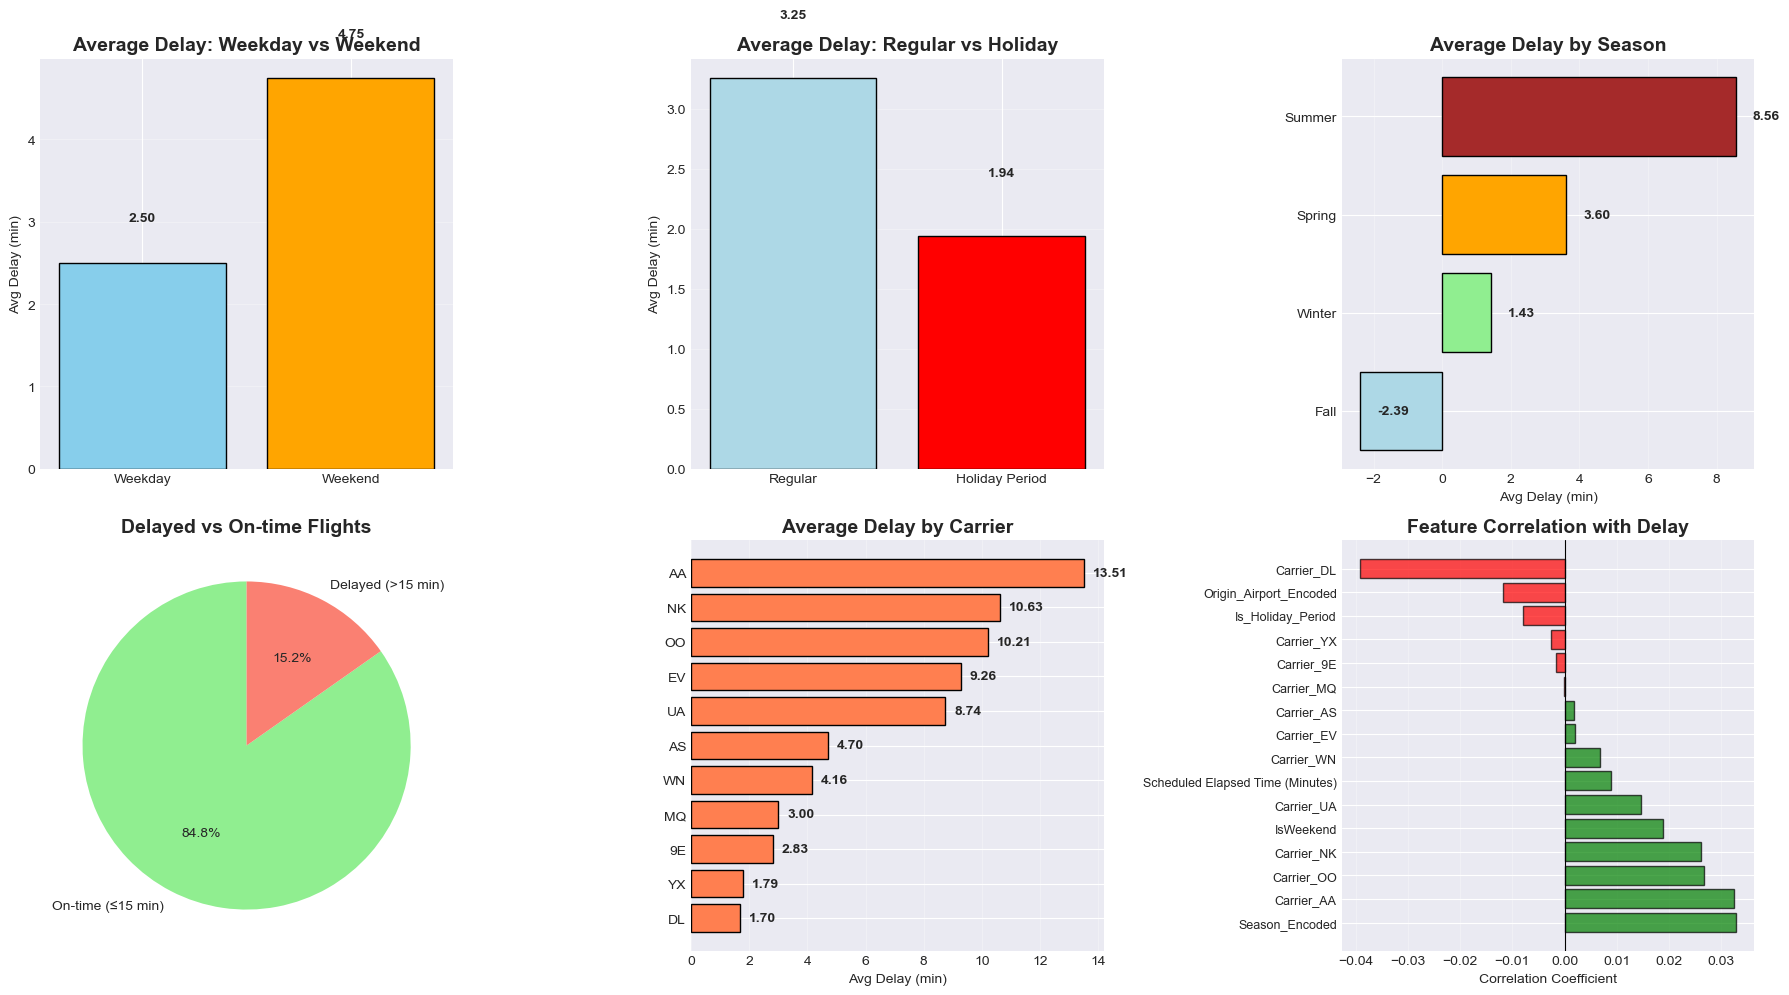

In [11]:
# Visualize new features
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# 1. Weekend vs Weekday Delays
weekend_delay = df_engineered.groupby('IsWeekend')['Arrival Delay (Minutes)'].mean()
axes[0, 0].bar(['Weekday', 'Weekend'], weekend_delay.values, color=['skyblue', 'orange'], edgecolor='black')
axes[0, 0].set_title('Average Delay: Weekday vs Weekend', fontsize=14, fontweight='bold')
axes[0, 0].set_ylabel('Avg Delay (min)')
axes[0, 0].grid(axis='y', alpha=0.3)
for i, v in enumerate(weekend_delay.values):
    axes[0, 0].text(i, v + 0.5, f'{v:.2f}', ha='center', fontweight='bold')

# 2. Holiday vs Regular Delays
holiday_delay = df_engineered.groupby('Is_Holiday_Period')['Arrival Delay (Minutes)'].mean()
axes[0, 1].bar(['Regular', 'Holiday Period'], holiday_delay.values, color=['lightblue', 'red'], edgecolor='black')
axes[0, 1].set_title('Average Delay: Regular vs Holiday', fontsize=14, fontweight='bold')
axes[0, 1].set_ylabel('Avg Delay (min)')
axes[0, 1].grid(axis='y', alpha=0.3)
for i, v in enumerate(holiday_delay.values):
    axes[0, 1].text(i, v + 0.5, f'{v:.2f}', ha='center', fontweight='bold')

# 3. Delay by Season (using encoded values)
season_mapping = {0: 'Fall', 1: 'Spring', 2: 'Summer', 3: 'Winter'}
season_delay = df_engineered.groupby('Season_Encoded')['Arrival Delay (Minutes)'].mean()
season_labels = [season_mapping[idx] for idx in season_delay.index]
season_delay_sorted = season_delay.sort_values()
season_labels_sorted = [season_mapping[idx] for idx in season_delay_sorted.index]
colors_season = ['lightblue', 'lightgreen', 'orange', 'brown']
axes[0, 2].barh(season_labels_sorted, season_delay_sorted.values, color=colors_season, edgecolor='black')
axes[0, 2].set_title('Average Delay by Season', fontsize=14, fontweight='bold')
axes[0, 2].set_xlabel('Avg Delay (min)')
axes[0, 2].grid(axis='x', alpha=0.3)
for i, v in enumerate(season_delay_sorted.values):
    axes[0, 2].text(v + 0.5, i, f'{v:.2f}', va='center', fontweight='bold')

# 4. Delayed vs On-time Distribution
delayed_dist = df_engineered['Is_Delayed'].value_counts()
axes[1, 0].pie(delayed_dist.values, labels=['On-time (≤15 min)', 'Delayed (>15 min)'], 
               autopct='%1.1f%%', startangle=90, colors=['lightgreen', 'salmon'])
axes[1, 0].set_title('Delayed vs On-time Flights', fontsize=14, fontweight='bold')

# 5. Delay by Carrier (reconstruct from one-hot encoded columns)
carrier_cols = [col for col in df_engineered.columns if col.startswith('Carrier_')]
carrier_delays = {}
for col in carrier_cols:
    carrier_name = col.replace('Carrier_', '')
    # Get mean delay for flights with this carrier (where dummy = 1)
    carrier_delays[carrier_name] = df_engineered[df_engineered[col] == 1]['Arrival Delay (Minutes)'].mean()

carrier_delay = pd.Series(carrier_delays).sort_values()
axes[1, 1].barh(carrier_delay.index, carrier_delay.values, color='coral', edgecolor='black')
axes[1, 1].set_title('Average Delay by Carrier', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Avg Delay (min)')
axes[1, 1].grid(axis='x', alpha=0.3)
for i, v in enumerate(carrier_delay.values):
    axes[1, 1].text(v + 0.3, i, f'{v:.2f}', va='center', fontweight='bold')

# 6. Feature Correlation with Target
numeric_features = df_engineered[feature_cols].select_dtypes(include=[np.number]).columns
correlations = df_engineered[numeric_features].corrwith(df_engineered['Arrival Delay (Minutes)']).sort_values(ascending=False)
top_corr = pd.concat([correlations.head(8), correlations.tail(8)])
colors_corr = ['green' if x > 0 else 'red' for x in top_corr.values]
axes[1, 2].barh(range(len(top_corr)), top_corr.values, color=colors_corr, alpha=0.7, edgecolor='black')
axes[1, 2].set_yticks(range(len(top_corr)))
axes[1, 2].set_yticklabels(top_corr.index, fontsize=9)
axes[1, 2].set_title('Feature Correlation with Delay', fontsize=14, fontweight='bold')
axes[1, 2].set_xlabel('Correlation Coefficient')
axes[1, 2].axvline(0, color='black', linewidth=0.8)
axes[1, 2].grid(axis='x', alpha=0.3)

plt.tight_layout()

# Save figure
figures_dir = Path('../results/figures')
figures_dir.mkdir(parents=True, exist_ok=True)
plt.savefig(figures_dir / 'feature_engineering_analysis.png', dpi=300, bbox_inches='tight')
print("Saved visualization to: ../results/figures/feature_engineering_analysis.png")
plt.show()

In [12]:
# Quick inspection
import pandas as pd

df = pd.read_csv('../data/processed/flight_delays_combined.csv')
print("Arrival Delay (Minutes) statistics:")
print(df['Arrival Delay (Minutes)'].describe())
print(f"\nNegative values (early arrivals): {(df['Arrival Delay (Minutes)'] < 0).sum()}")
print(f"Positive values (delays): {(df['Arrival Delay (Minutes)'] > 0).sum()}")
print(f"Zero (on-time): {(df['Arrival Delay (Minutes)'] == 0).sum()}")

Arrival Delay (Minutes) statistics:
count    1.527160e+06
mean     3.105137e+00
std      5.249457e+01
min     -8.600000e+01
25%     -1.600000e+01
50%     -8.000000e+00
75%      3.000000e+00
max      1.694000e+03
Name: Arrival Delay (Minutes), dtype: float64

Negative values (early arrivals): 1037860
Positive values (delays): 444253
Zero (on-time): 45047


---
## Part 4: Regression Feature Engineering
---

In [13]:
# Cell: Import regression pipeline
from src.data.preprocessing import preprocessing_pipeline_regression
from src.data.feature_engineering import feature_engineering_pipeline_regression

print("✓ Regression pipeline imports complete")

✓ Regression pipeline imports complete


In [14]:
# Cell: Step 1 - Preprocess for regression (remove extreme outliers)
print("="*80)
print("STEP 1: PREPROCESSING FOR REGRESSION")
print("="*80)

input_path_regression = '../data/processed/flight_delays_combined.csv'
cleaned_path_regression = '../data/processed/flight_delays_cleaned_regression.csv'

df_cleaned_regression = preprocessing_pipeline_regression(
    input_path=input_path_regression,
    output_path=cleaned_path_regression,
    remove_invalid=True,
    handle_missing=True,
    remove_dupes=True,
    validate_dtypes=True,
    handle_outliers_method='keep',
    regression_cap_min=-60,      # Remove delays < -60 min (1 hour early)
    regression_cap_max=300,      # Remove delays > 300 min (5 hours late)
    date_range=None
)

print("\n✓ Regression preprocessing complete!")
print(f"✓ Cleaned dataset shape: {df_cleaned_regression.shape}")

STEP 1: PREPROCESSING FOR REGRESSION
STARTING REGRESSION PREPROCESSING PIPELINE

Loading data from: ../data/processed/flight_delays_combined.csv
Loaded 1,527,171 rows, 17 columns
Created canonical date column 'Date (YYYY-MM-DD)'
REMOVING INVALID ROWS
Removed 11 rows with 15 critical columns missing (0.0007%)
Remaining: 1,527,160 rows
HANDLING MISSING VALUES
Initial missing values: 1,068
  - Tail Number: Filled 1068 values with 'Unknown'

 Final missing values: 0
Reduced missing values by 1,068
REMOVING DUPLICATES
Removed 0 duplicate rows (0.00%)
Remaining: 1,527,160 rows
VALIDATING DATA TYPES
✓ Converted 'Flight Number' from float64 to Int32
✓ Converted 'Scheduled Elapsed Time (Minutes)' from float64 to Int16
✓ Converted 'Actual Elapsed Time (Minutes)' from float64 to Int16
✓ Converted 'Arrival Delay (Minutes)' from float64 to Int16
✓ Converted 'Taxi-In time (Minutes)' from float64 to Int16
✓ Converted 'Delay Carrier (Minutes)' from float64 to Int16
✓ Converted 'Delay Weather (Minutes)

In [15]:
# Cell: Step 2 - Feature engineering for regression
print("="*80)
print("STEP 2: FEATURE ENGINEERING FOR REGRESSION")
print("="*80)

engineered_path_regression = '../data/processed/flight_delays_engineered_regression.csv'

df_engineered_regression, feature_cols_regression, label_encoders_regression = feature_engineering_pipeline_regression(
    input_path=cleaned_path_regression,
    output_path=engineered_path_regression
)

print("\n✓ Regression feature engineering complete!")
print(f"\nFinal regression dataset:")
print(f"  - Rows: {len(df_engineered_regression):,}")
print(f"  - Features: {len(feature_cols_regression)}")
print(f"  - Target: Arrival Delay (Minutes) (continuous)")

print(f"\nFeature list:")
for i, col in enumerate(feature_cols_regression, 1):
    print(f"  {i:2}. {col}")

STEP 2: FEATURE ENGINEERING FOR REGRESSION
FEATURE ENGINEERING PIPELINE (REGRESSION)

Loading data from: ../data/processed/flight_delays_cleaned_regression.csv
Loaded 1,519,602 rows, 17 columns
CREATING BASIC FEATURES
✓ Created IsWeekend
✓ Created Is_Holiday_Period
Created Season
Created Is_Delayed

Feature summary:
  - IsWeekend: 407,373 (26.81%)
  - Is_Holiday_Period: 171,871 (11.31%)
  - Season: {'Spring': 422740, 'Summer': 404615, 'Winter': 360992, 'Fall': 331255}
  - Is_Delayed: 225,318 (14.83%)

ENCODING CATEGORICAL FEATURES

One-hot encoding Carrier Code...
Created 11 carrier dummy variables

Label encoding Origin Airport...
Encoded 173 unique airports

Label encoding Season...
Encoded Season: {'Fall': np.int64(0), 'Spring': np.int64(1), 'Summer': np.int64(2), 'Winter': np.int64(3)}

 Encoding complete. Total columns: 36
SELECTING FEATURES FOR MODELING

Total features: 16

Features for modeling:
   1. Scheduled Elapsed Time (Minutes)
   2. IsWeekend
   3. Is_Holiday_Period
   4.

In [16]:
# Cell: Compare classification vs regression datasets
print("="*80)
print("CLASSIFICATION vs REGRESSION DATASETS")
print("="*80)

print(f"\n📊 CLASSIFICATION Dataset:")
print(f"   File: flight_delays_engineered.csv")
print(f"   Rows: {len(df_engineered):,}")
print(f"   Features: {len(feature_cols)}")
print(f"   Targets: 2 (Arrival Delay + Is_Delayed)")
print(f"   Target types: Continuous + Binary")

print(f"\n📈 REGRESSION Dataset:")
print(f"   File: flight_delays_engineered_regression.csv")
print(f"   Rows: {len(df_engineered_regression):,}")
print(f"   Features: {len(feature_cols_regression)}")
print(f"   Target: 1 (Arrival Delay only)")
print(f"   Target type: Continuous")

# Data reduction from outlier removal
original_count = len(df)
regression_count = len(df_engineered_regression)
removed = original_count - regression_count
print(f"\n🗑️ Outliers removed: {removed:,} rows ({removed/original_count*100:.4f}%)")

CLASSIFICATION vs REGRESSION DATASETS

📊 CLASSIFICATION Dataset:
   File: flight_delays_engineered.csv
   Rows: 1,527,160
   Features: 16
   Targets: 2 (Arrival Delay + Is_Delayed)
   Target types: Continuous + Binary

📈 REGRESSION Dataset:
   File: flight_delays_engineered_regression.csv
   Rows: 1,519,602
   Features: 16
   Target: 1 (Arrival Delay only)
   Target type: Continuous

🗑️ Outliers removed: 7,569 rows (0.4956%)



✓ Saved: ../results/figures/regression_target_analysis.png


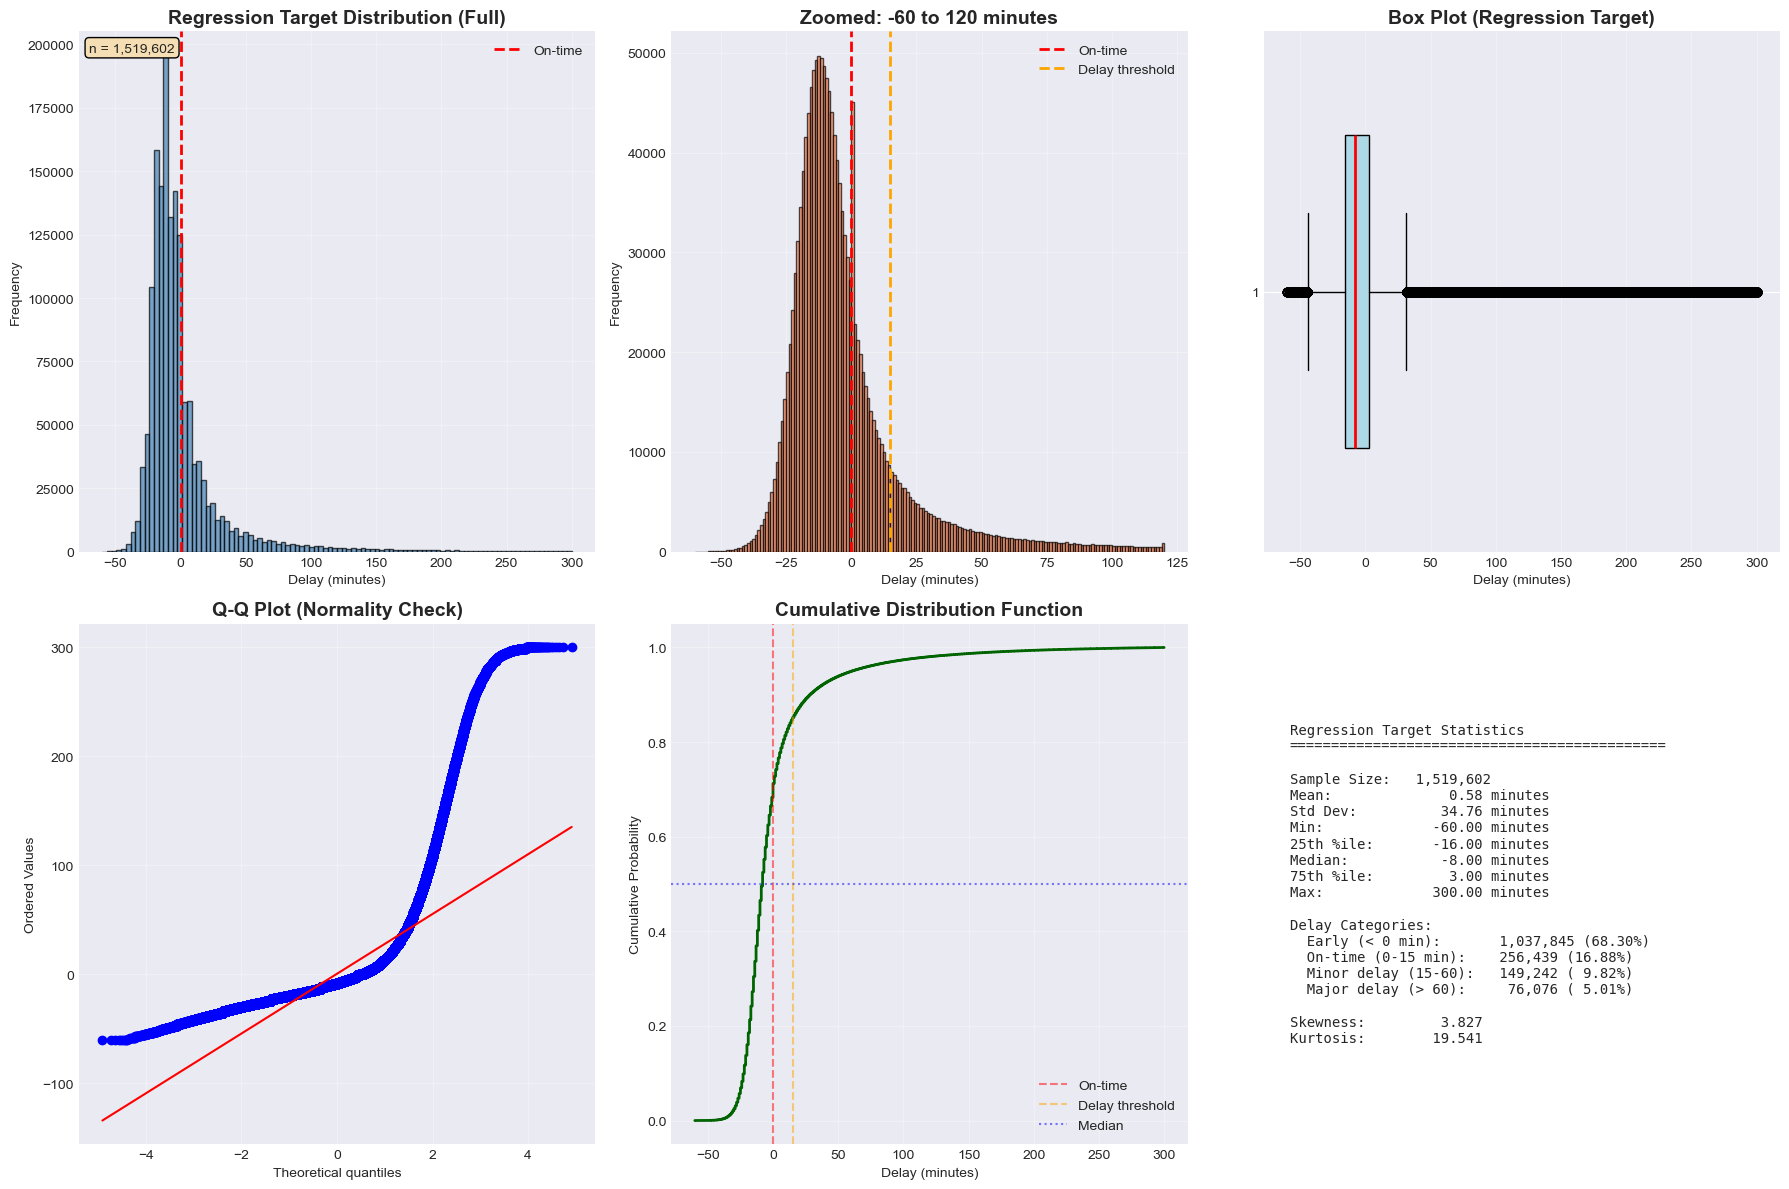

In [17]:
# Cell: Visualize regression target distribution
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

target_reg = df_engineered_regression['Arrival Delay (Minutes)']

# 1. Full distribution histogram
axes[0, 0].hist(target_reg, bins=100, edgecolor='black', alpha=0.7, color='steelblue')
axes[0, 0].set_title('Regression Target Distribution (Full)', fontweight='bold', fontsize=14)
axes[0, 0].set_xlabel('Delay (minutes)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].axvline(0, color='red', linestyle='--', linewidth=2, label='On-time')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)
axes[0, 0].text(0.02, 0.98, f'n = {len(target_reg):,}', transform=axes[0, 0].transAxes,
                va='top', ha='left', bbox=dict(boxstyle='round', facecolor='wheat'))

# 2. Zoomed distribution (-60 to 120 min)
axes[0, 1].hist(target_reg, bins=180, range=(-60, 120), 
                edgecolor='black', alpha=0.7, color='coral')
axes[0, 1].set_title('Zoomed: -60 to 120 minutes', fontweight='bold', fontsize=14)
axes[0, 1].set_xlabel('Delay (minutes)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].axvline(0, color='red', linestyle='--', linewidth=2, label='On-time')
axes[0, 1].axvline(15, color='orange', linestyle='--', linewidth=2, label='Delay threshold')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# 3. Box plot
bp = axes[0, 2].boxplot(target_reg, vert=False, patch_artist=True, widths=0.6)
bp['boxes'][0].set_facecolor('lightblue')
bp['medians'][0].set_color('red')
bp['medians'][0].set_linewidth(2)
axes[0, 2].set_title('Box Plot (Regression Target)', fontweight='bold', fontsize=14)
axes[0, 2].set_xlabel('Delay (minutes)')
axes[0, 2].grid(axis='x', alpha=0.3)

# 4. Q-Q plot (normality check)
from scipy import stats
stats.probplot(target_reg, dist="norm", plot=axes[1, 0])
axes[1, 0].set_title('Q-Q Plot (Normality Check)', fontweight='bold', fontsize=14)
axes[1, 0].grid(alpha=0.3)

# 5. Cumulative distribution
sorted_delays = np.sort(target_reg)
cumulative = np.arange(1, len(sorted_delays) + 1) / len(sorted_delays)
axes[1, 1].plot(sorted_delays, cumulative, linewidth=2, color='darkgreen')
axes[1, 1].set_title('Cumulative Distribution Function', fontweight='bold', fontsize=14)
axes[1, 1].set_xlabel('Delay (minutes)')
axes[1, 1].set_ylabel('Cumulative Probability')
axes[1, 1].axvline(0, color='red', linestyle='--', alpha=0.5, label='On-time')
axes[1, 1].axvline(15, color='orange', linestyle='--', alpha=0.5, label='Delay threshold')
axes[1, 1].axhline(0.5, color='blue', linestyle=':', alpha=0.5, label='Median')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

# 6. Statistics table
stats_summary = target_reg.describe()
axes[1, 2].axis('off')

stats_text = f"""
Regression Target Statistics
{'='*45}

Sample Size:   {stats_summary['count']:,.0f}
Mean:          {stats_summary['mean']:>8.2f} minutes
Std Dev:       {stats_summary['std']:>8.2f} minutes
Min:           {stats_summary['min']:>8.2f} minutes
25th %ile:     {stats_summary['25%']:>8.2f} minutes
Median:        {stats_summary['50%']:>8.2f} minutes
75th %ile:     {stats_summary['75%']:>8.2f} minutes
Max:           {stats_summary['max']:>8.2f} minutes

Delay Categories:
  Early (< 0 min):       {(target_reg < 0).sum():>7,} ({(target_reg < 0).mean()*100:>5.2f}%)
  On-time (0-15 min):    {((target_reg >= 0) & (target_reg <= 15)).sum():>7,} ({((target_reg >= 0) & (target_reg <= 15)).mean()*100:>5.2f}%)
  Minor delay (15-60):   {((target_reg > 15) & (target_reg <= 60)).sum():>7,} ({((target_reg > 15) & (target_reg <= 60)).mean()*100:>5.2f}%)
  Major delay (> 60):    {(target_reg > 60).sum():>7,} ({(target_reg > 60).mean()*100:>5.2f}%)

Skewness:      {target_reg.skew():>8.3f}
Kurtosis:      {target_reg.kurtosis():>8.3f}
"""

axes[1, 2].text(0.05, 0.5, stats_text, fontsize=10, family='monospace',
                verticalalignment='center', transform=axes[1, 2].transAxes)

plt.tight_layout()

# Save figure
figures_dir = Path('../results/figures')
figures_dir.mkdir(parents=True, exist_ok=True)
plt.savefig(figures_dir / 'regression_target_analysis.png', dpi=300, bbox_inches='tight')
print("\n✓ Saved: ../results/figures/regression_target_analysis.png")
plt.show()

✓ Saved: ../results/figures/classification_vs_regression_comparison.png


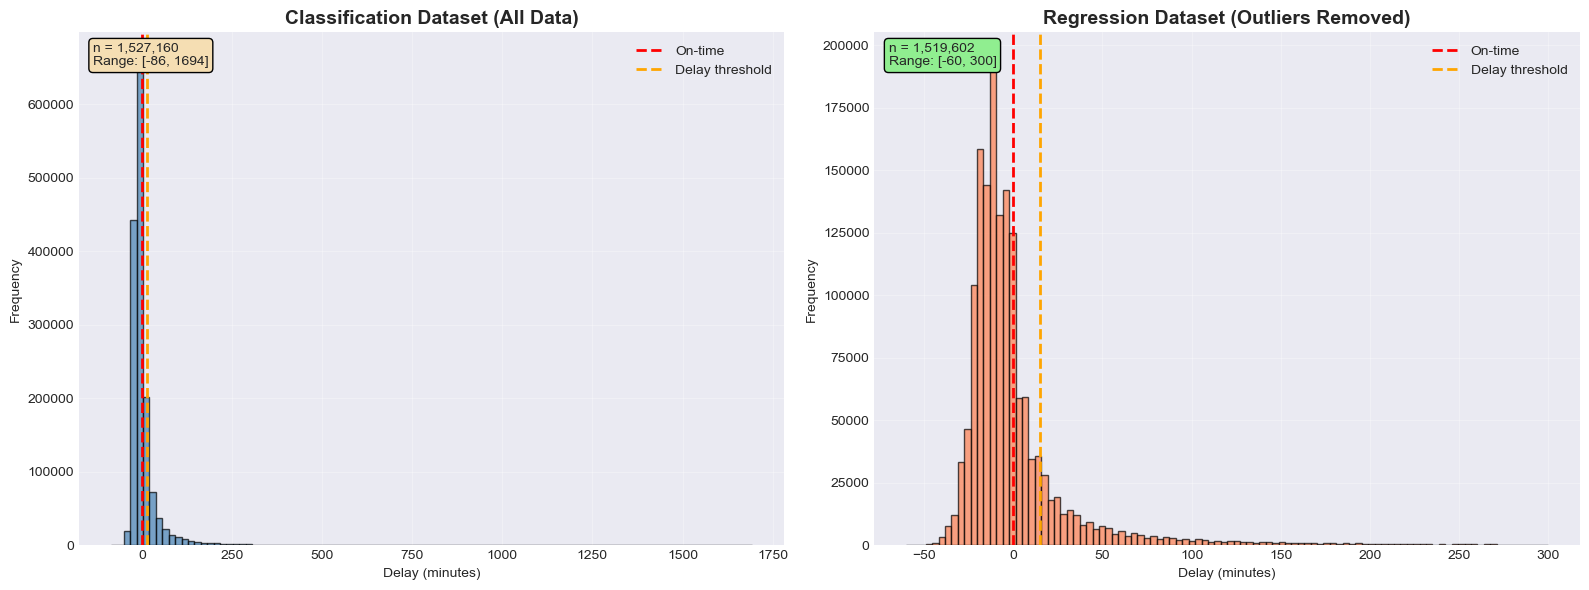


DISTRIBUTION COMPARISON

Metric                    Classification       Regression           Change         
--------------------------------------------------------------------------------
Count                               1,527,160           1,519,602          7,558
Mean (minutes)                           3.11                0.58           2.52
Std Dev (minutes)                       52.49               34.76          17.74
Min (minutes)                          -86.00              -60.00         -26.00
Max (minutes)                         1694.00              300.00        1394.00
Median (minutes)                        -8.00               -8.00           0.00


In [18]:
# Cell: Compare distributions - Classification vs Regression
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Original (classification) - includes all data
target_class = df_engineered['Arrival Delay (Minutes)']

# Cleaned (regression) - outliers removed
target_reg = df_engineered_regression['Arrival Delay (Minutes)']

# 1. Classification dataset
axes[0].hist(target_class, bins=100, edgecolor='black', alpha=0.7, color='steelblue')
axes[0].set_title('Classification Dataset (All Data)', fontweight='bold', fontsize=14)
axes[0].set_xlabel('Delay (minutes)')
axes[0].set_ylabel('Frequency')
axes[0].axvline(0, color='red', linestyle='--', linewidth=2, label='On-time')
axes[0].axvline(15, color='orange', linestyle='--', linewidth=2, label='Delay threshold')
axes[0].legend()
axes[0].grid(alpha=0.3)
axes[0].text(0.02, 0.98, f'n = {len(target_class):,}\nRange: [{target_class.min():.0f}, {target_class.max():.0f}]',
             transform=axes[0].transAxes, va='top', ha='left',
             bbox=dict(boxstyle='round', facecolor='wheat'))

# 2. Regression dataset
axes[1].hist(target_reg, bins=100, edgecolor='black', alpha=0.7, color='coral')
axes[1].set_title('Regression Dataset (Outliers Removed)', fontweight='bold', fontsize=14)
axes[1].set_xlabel('Delay (minutes)')
axes[1].set_ylabel('Frequency')
axes[1].axvline(0, color='red', linestyle='--', linewidth=2, label='On-time')
axes[1].axvline(15, color='orange', linestyle='--', linewidth=2, label='Delay threshold')
axes[1].legend()
axes[1].grid(alpha=0.3)
axes[1].text(0.02, 0.98, f'n = {len(target_reg):,}\nRange: [{target_reg.min():.0f}, {target_reg.max():.0f}]',
             transform=axes[1].transAxes, va='top', ha='left',
             bbox=dict(boxstyle='round', facecolor='lightgreen'))

plt.tight_layout()
plt.savefig(figures_dir / 'classification_vs_regression_comparison.png', dpi=300, bbox_inches='tight')
print("✓ Saved: ../results/figures/classification_vs_regression_comparison.png")
plt.show()

# Print comparison statistics
print("\n" + "="*80)
print("DISTRIBUTION COMPARISON")
print("="*80)
print(f"\n{'Metric':<25} {'Classification':<20} {'Regression':<20} {'Change':<15}")
print("-" * 80)
print(f"{'Count':<25} {len(target_class):>19,} {len(target_reg):>19,} {len(target_class)-len(target_reg):>14,}")
print(f"{'Mean (minutes)':<25} {target_class.mean():>19.2f} {target_reg.mean():>19.2f} {target_class.mean()-target_reg.mean():>14.2f}")
print(f"{'Std Dev (minutes)':<25} {target_class.std():>19.2f} {target_reg.std():>19.2f} {target_class.std()-target_reg.std():>14.2f}")
print(f"{'Min (minutes)':<25} {target_class.min():>19.2f} {target_reg.min():>19.2f} {target_class.min()-target_reg.min():>14.2f}")
print(f"{'Max (minutes)':<25} {target_class.max():>19.2f} {target_reg.max():>19.2f} {target_class.max()-target_reg.max():>14.2f}")
print(f"{'Median (minutes)':<25} {target_class.median():>19.2f} {target_reg.median():>19.2f} {target_class.median()-target_reg.median():>14.2f}")

In [19]:
# Cell: Final summary
print("="*80)
print("REGRESSION FEATURE ENGINEERING COMPLETE ✓")
print("="*80)

print("\n📁 Generated Files:")
print(f"  1. {cleaned_path_regression}")
print(f"     - Preprocessed data with outliers removed")
print(f"     - Rows: {len(df_cleaned_regression):,}")

print(f"\n  2. {engineered_path_regression}")
print(f"     - Engineered features for regression")
print(f"     - Rows: {len(df_engineered_regression):,}")
print(f"     - Features: {len(feature_cols_regression)}")
print(f"     - Target: Arrival Delay (Minutes)")

print("\n📊 Key Statistics:")
print(f"  - Outliers removed: {len(df)-len(df_engineered_regression):,} ({(len(df)-len(df_engineered_regression))/len(df)*100:.4f}%)")
print(f"  - Target range: [{target_reg.min():.0f}, {target_reg.max():.0f}] minutes")
print(f"  - Mean delay: {target_reg.mean():.2f} minutes")
print(f"  - Median delay: {target_reg.median():.2f} minutes")

print("\n🎯 Ready for regression modeling!")
print("   - Linear Regression")
print("   - Random Forest Regressor")
print("   - XGBoost Regressor")
print("   - LightGBM Regressor")

print("\n✅ Next step: Create regression model training notebook (04_model_training_regression.ipynb)")

REGRESSION FEATURE ENGINEERING COMPLETE ✓

📁 Generated Files:
  1. ../data/processed/flight_delays_cleaned_regression.csv
     - Preprocessed data with outliers removed
     - Rows: 1,519,602

  2. ../data/processed/flight_delays_engineered_regression.csv
     - Engineered features for regression
     - Rows: 1,519,602
     - Features: 16
     - Target: Arrival Delay (Minutes)

📊 Key Statistics:
  - Outliers removed: 7,569 (0.4956%)
  - Target range: [-60, 300] minutes
  - Mean delay: 0.58 minutes
  - Median delay: -8.00 minutes

🎯 Ready for regression modeling!
   - Linear Regression
   - Random Forest Regressor
   - XGBoost Regressor
   - LightGBM Regressor

✅ Next step: Create regression model training notebook (04_model_training_regression.ipynb)
